In [1]:
import cellcharter as cc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata as ad
from scipy.stats import mannwhitneyu, spearmanr, kruskal
import scikit_posthocs as sp
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import json
import os
import re
import warnings
warnings.filterwarnings("ignore")

/Users/lukashat/miniforge3/envs/cellcharter_scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [ ]:
extension = 'svg'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_5/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_5/{extension}/'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/neighborhood_color_map.json', 'r') as f:
    neighborhood_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/phenotype_color_map.json', 'r') as f:
    phenotype_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease_color_map.json', 'r') as f:
    disease_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease3_color_map.json', 'r') as f:
    disease3_color_map = json.load(f)
neighborhood_colors = [neighborhood_color_map[cat] for cat in list(adata.obs['cellcharter_CN'].cat.categories)]
neighborhood_colors = ListedColormap(neighborhood_colors)
phenotype_colors = [phenotype_color_map[cat] for cat in list(adata.obs['Phenotype4'].cat.categories)]
phenotype_colors = ListedColormap(phenotype_colors)
disease_colors = [disease_color_map[cat] for cat in list(adata.obs['disease2'].cat.categories)]
disease_colors = ListedColormap(disease_colors)
disease3_colors = [disease3_color_map[cat] for cat in list(adata.obs['disease3'].cat.categories)]
disease3_colors = ListedColormap(disease3_colors)

# C-D

In [3]:
connectivity_dict = {'PC_OXPHOS': [],
 'PC_MYELOID': [],
 'BONE_VASCULATURE': [],
 'HIF1A_IMMUNE': [],
 'PROLIF_GLYC': [],
 'BONE_MYELOID': [],
 'ADIPOCYTES_PC': [],
 'ADAPTIVE_IMMUNE': []}
for i in np.arange(1, 311, 10):
    adata_i = adata.copy()
    cc.gr.connected_components(adata_i, cluster_key='cellcharter_CN', min_cells=i)
    current_dict= adata_i[~adata_i.obs['component'].isna()].obs['cellcharter_CN'].value_counts().to_dict()
    for key in connectivity_dict.keys():
        try:
            connectivity_dict[key].append(current_dict[key])
        except:
            raise ValueError(f'Key {key} not found in current_dict')
    del adata_i, current_dict
connectivity_df = pd.DataFrame(connectivity_dict)
connectivity_df_norm = connectivity_df.div(connectivity_df.iloc[0])
connectivity_df_norm['min_cells'] = np.arange(1, 311, 10)
connectivity_df_norm.set_index('min_cells', inplace=True)
connectivity_df_norm.head(10)

,PC_OXPHOS,PC_MYELOID,BONE_VASCULATURE,HIF1A_IMMUNE,PROLIF_GLYC,BONE_MYELOID,ADIPOCYTES_PC,ADAPTIVE_IMMUNE
min_cells,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
11,0.842674,0.699592,0.796633,0.627341,0.704076,0.694888,0.578077,0.729792
21,0.795484,0.582941,0.725875,0.509431,0.552144,0.580529,0.440951,0.659056
31,0.765026,0.485659,0.671542,0.432614,0.444073,0.494429,0.363955,0.601582
41,0.740908,0.421470,0.627961,0.380353,0.373331,0.430593,0.300187,0.565067
51,0.718389,0.369029,0.588763,0.328503,0.314381,0.374663,0.261005,0.536884
61,0.700650,0.334752,0.562612,0.298790,0.271233,0.333063,0.228783,0.513920
71,0.685709,0.301966,0.541550,0.271329,0.234445,0.288936,0.198876,0.494885
81,0.668355,0.263475,0.519704,0.252938,0.201703,0.257424,0.177083,0.477195


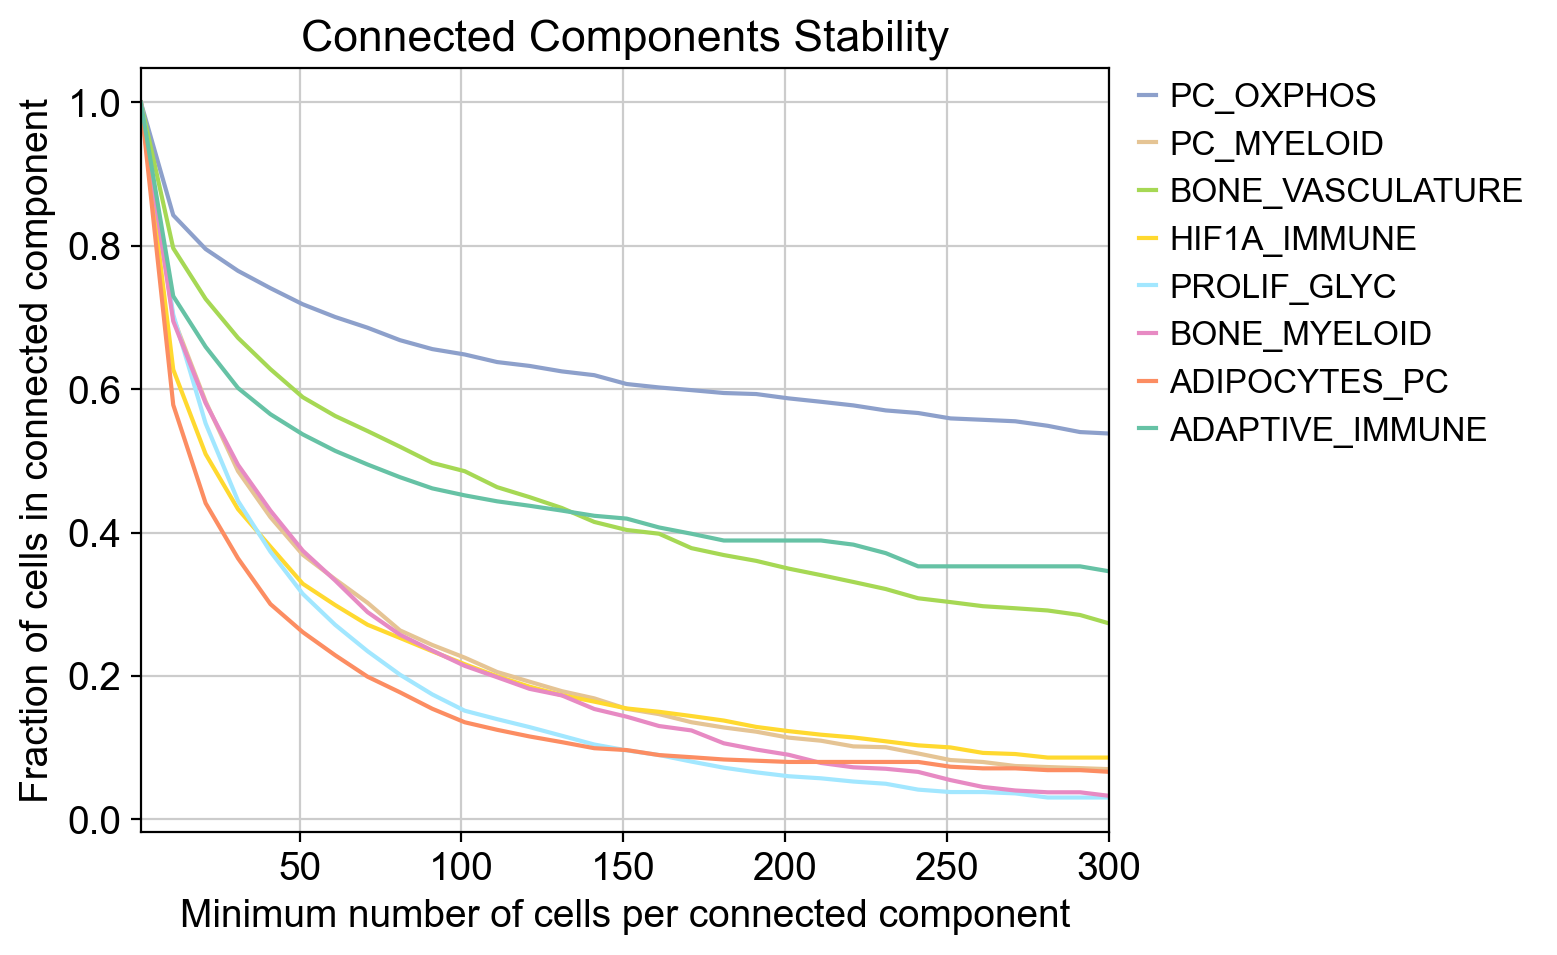

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
connectivity_df_norm.plot(ax=ax, color=neighborhood_color_map,)
ax.set_xlabel('Minimum number of cells per connected component', fontsize=14)
ax.set_ylabel('Fraction of cells in connected component', fontsize=14)
ax.set_xlim(1, 300)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left', framealpha=0, fontsize=12)
ax.set_title('Connected Components Stability', fontsize=16)
plt.tight_layout()
fig.savefig(os.path.join(save_path, f'connected_components_stability.{extension}'))

In [5]:
keys = list(adata.obs['cellcharter_CN'].cat.categories)
connectivity_dict = {
    'MM': {k: [] for k in keys},
    'SMM': {k: [] for k in keys},
    'MGUS': {k: [] for k in keys}
}

for i in np.arange(1, 311, 10):
    adata_iter = adata.copy()
    cc.gr.connected_components(adata_iter, cluster_key='cellcharter_CN', min_cells=i)

    filtered = adata_iter[~adata_iter.obs['component'].isna()]
    
    for disease, group in filtered.obs.groupby('disease3'):
        if disease not in connectivity_dict:
            continue
            
        counts = group['cellcharter_CN'].value_counts()
        for key in keys:
            connectivity_dict[disease][key].append(counts.get(key, 0))
    
    del adata_iter, filtered
connectivity_df_mm = pd.DataFrame(connectivity_dict['MM'])
connectivity_df_smm = pd.DataFrame(connectivity_dict['SMM'])
connectivity_df_mgus = pd.DataFrame(connectivity_dict['MGUS'])
connectivity_df_mm_norm = connectivity_df_mm.div(connectivity_df_mm.iloc[0])
connectivity_df_smm_norm = connectivity_df_smm.div(connectivity_df_smm.iloc[0])
connectivity_df_mgus_norm = connectivity_df_mgus.div(connectivity_df_mgus.iloc[0])
connectivity_df_mm_norm['min_cells'] = np.arange(1, 311, 10)
connectivity_df_smm_norm['min_cells'] = np.arange(1, 311, 10)
connectivity_df_mgus_norm['min_cells'] = np.arange(1, 311, 10)
connectivity_df_mm_norm.set_index('min_cells', inplace=True)
connectivity_df_smm_norm.set_index('min_cells', inplace=True)
connectivity_df_mgus_norm.set_index('min_cells', inplace=True)



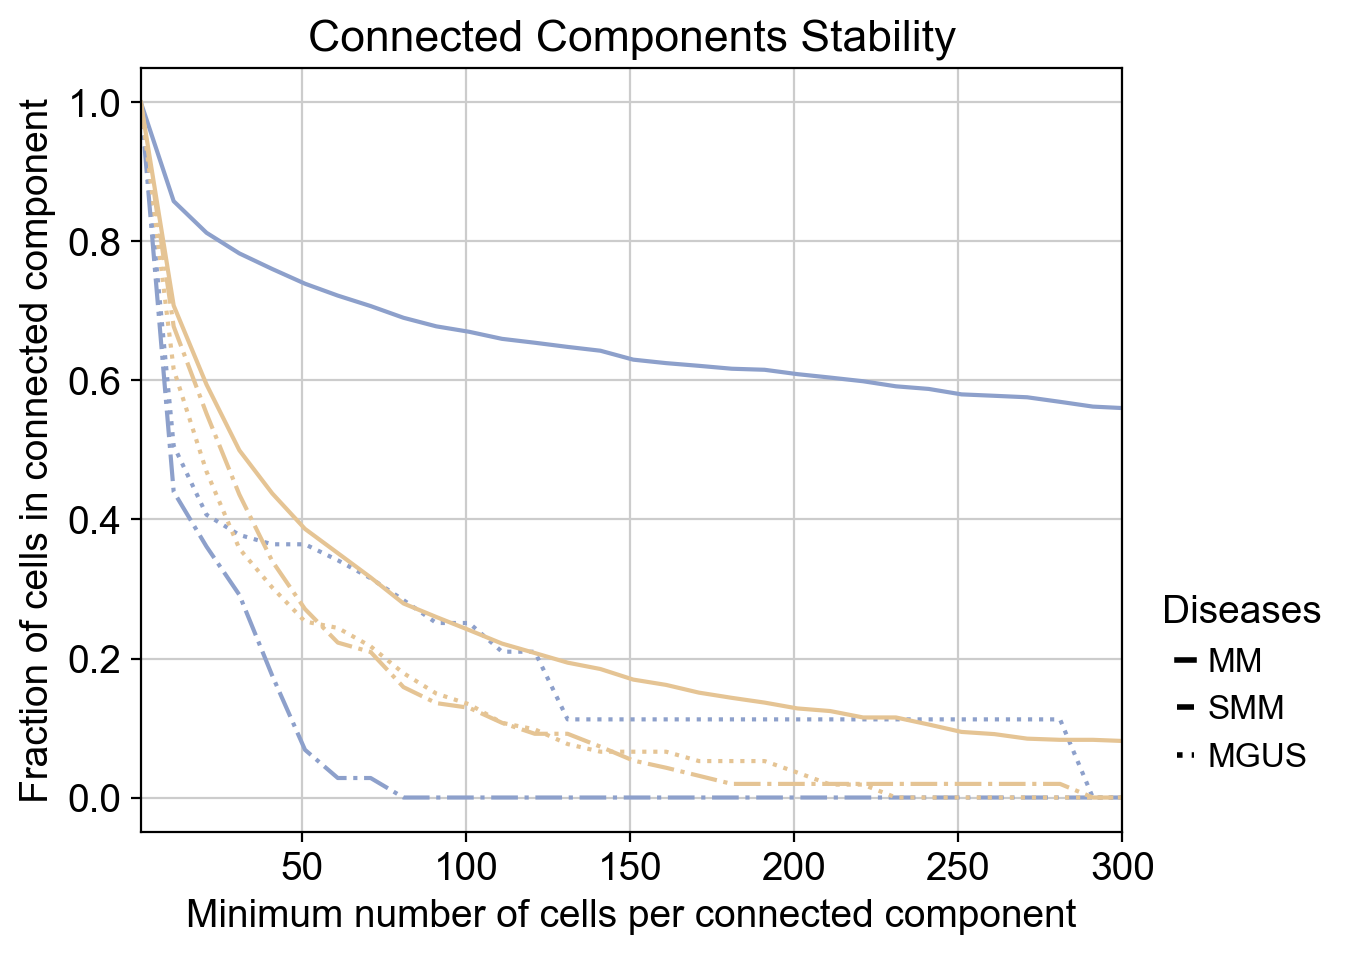

In [7]:
connectivity_df_mm_norm = connectivity_df_mm_norm[['PC_OXPHOS', 'PC_MYELOID']]
connectivity_df_smm_norm = connectivity_df_smm_norm[['PC_OXPHOS', 'PC_MYELOID']]
connectivity_df_mgus_norm = connectivity_df_mgus_norm[['PC_OXPHOS', 'PC_MYELOID']]
fig, ax = plt.subplots(figsize=(7, 5))

# Create unified plotting parameters
linestyles = {'MM': '-', 'SMM': '-.', 'MGUS': ':'}

# Plot all lines with combined legend strategy
for neighborhood in connectivity_df_mm_norm.columns:
    base_color = neighborhood_color_map[neighborhood]

    ax.plot(connectivity_df_mm_norm[neighborhood], 
            color=base_color, 
            linestyle=linestyles['MM'],
            label='_nolegend_')  # Hide individual labels
    
    ax.plot(connectivity_df_smm_norm[neighborhood], 
            color=base_color, 
            linestyle=linestyles['SMM'],
            label='_nolegend_')
    
    ax.plot(connectivity_df_mgus_norm[neighborhood], 
            color=base_color, 
            linestyle=linestyles['MGUS'],
            label='_nolegend_')


color_legend = [Line2D([0], [0], color=neighborhood_color_map[n], lw=2, label=n) 
                for n in neighborhood_color_map]

line_legend = [Line2D([0], [0], color='black', linestyle=linestyles[d], lw=2, label=d)
               for d in linestyles]

# first_legend = ax.legend(handles=color_legend, 
#                         bbox_to_anchor=(1.01, 1.03), 
#                         loc='upper left',
#                         framealpha=0,
#                         title="Neighborhoods",
#                         title_fontsize=14,
#                         fontsize=12)

#ax.add_artist(first_legend)
ax.legend(handles=line_legend, 
         bbox_to_anchor=(1.01, 0.35), 
         loc='upper left',
         framealpha=0,
         title="Diseases",
         title_fontsize=14,
         fontsize=12)

# Formatting
ax.set_xlabel('Minimum number of cells per connected component', fontsize=14)
ax.set_ylabel('Fraction of cells in connected component', fontsize=14)
ax.set_xlim(1, 300)
ax.set_title('Connected Components Stability', fontsize=16)
fig.tight_layout()
plt.tight_layout()
plt.savefig(
    os.path.join(save_path, f'connected_components_stability_disease_pc_nbh.{extension}')
)

## E

In [8]:
csv = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/dirSEA/250326COZI_phenotype4_normalized.csv')
csv.rename(columns={'Unnamed: 0': 'image_ID'}, inplace=True)
csv['image_ID'] = csv['image_ID'].replace({'TS-373_IMC42_B_ROI_2.csv': 'TS-373_IMC42_B_002.csv'})
disease_mapping = adata.obs[['disease3', 'image_ID']].drop_duplicates()
disease_mapping.set_index('image_ID', inplace=True)
csv['disease3'] = csv['image_ID'].map(disease_mapping['disease3'])
disease_order = ['MM', 'SMM', 'MGUS']
csv['disease3'] = pd.Categorical(csv['disease3'], 
                                categories=disease_order, 
                                ordered=True)

In [9]:
targets = ['image_ID','Plasma Cells/MM cells_Endothelial cells']
pattern = '|'.join(map(re.escape, targets))
interactions = csv.filter(regex=pattern, axis=1)
interactions['disease3'] = interactions['image_ID'].map(disease_mapping['disease3'])
interactions['disease3'] = pd.Categorical(interactions['disease3'], 
                                categories=disease_order, 
                                ordered=True)
interactions = interactions.sort_values('disease3')
interactions = interactions.replace([np.inf, -np.inf], np.nan)
interactions.dropna(inplace=True)
interactions.rename(columns={'Plasma Cells/MM cells_Endothelial cells': 'PCs*Endothelial'}, inplace=True)
interactions

,image_ID,PCs*Endothelial,disease3
0,TS-373_IMC77_B_001.csv,0.006928,MM
105,TS-373_IMC21_UB_001.csv,0.186633,MM
103,TS-373_IMC23_B_001.csv,0.095765,MM
102,TS-373_IMC84_B_001.csv,0.148333,MM
101,TS-373_IMC89_B_002.csv,0.079346,MM
...,...,...,...
49,TS-373_IMC02_MGUS_001.csv,0.061113,MGUS
15,TS-373_IMC04_MGUS_001.csv,0.032948,MGUS
14,TS-373_IMC03_MGUS_001.csv,0.037984,MGUS
35,TS-373_IMC02_MGUS_002.csv,0.067801,MGUS


In [10]:
interactions_melt = interactions.melt(
    id_vars=['image_ID', 'disease3'],
    value_vars= [
        'PCs*Endothelial',
    ],
    var_name='interaction',
    value_name='z-score'
)
interactions_melt

,image_ID,disease3,interaction,z-score
0,TS-373_IMC77_B_001.csv,MM,PCs*Endothelial,0.006928
1,TS-373_IMC21_UB_001.csv,MM,PCs*Endothelial,0.186633
2,TS-373_IMC23_B_001.csv,MM,PCs*Endothelial,0.095765
3,TS-373_IMC84_B_001.csv,MM,PCs*Endothelial,0.148333
4,TS-373_IMC89_B_002.csv,MM,PCs*Endothelial,0.079346
...,...,...,...,...
147,TS-373_IMC02_MGUS_001.csv,MGUS,PCs*Endothelial,0.061113
148,TS-373_IMC04_MGUS_001.csv,MGUS,PCs*Endothelial,0.032948
149,TS-373_IMC03_MGUS_001.csv,MGUS,PCs*Endothelial,0.037984
150,TS-373_IMC02_MGUS_002.csv,MGUS,PCs*Endothelial,0.067801


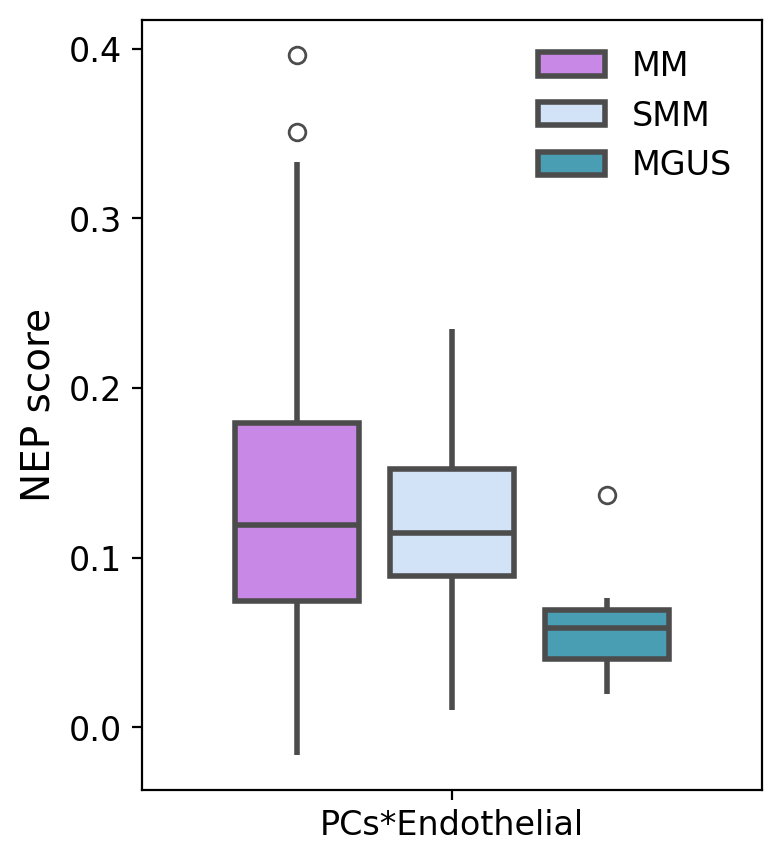

In [11]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(4, 5))
sns.boxplot(
    x='interaction',
    y='z-score',
    hue='disease3',
    data=interactions_melt,
    palette=disease3_color_map,
    showcaps=False,
    linewidth=2,
    width=0.75,
    gap=0.2,
    ax=ax
)
ax.set_xlabel('')
ax.set_ylabel('NEP score', fontsize=14)
ax.set_yticklabels([f"{y:.1f}" for y in ax.get_yticks()], fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
plt.legend(title='', fontsize=12, framealpha=0)
plt.title('', fontsize=16)
plt.savefig(os.path.join(save_path, f'interaction_pc_ec_dirSEA.{extension}'))

In [12]:
targets = ['MM', 'SMM', 'MGUS']
filtered_df = interactions_melt[interactions_melt['disease3'].isin(targets)]
groups = [group['z-score'].values for _, group in filtered_df.groupby('disease3')]
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis H-stat: {kruskal_result.statistic:.3f}, p-val: {kruskal_result.pvalue:.4f}")

Kruskal-Wallis H-stat: 11.086, p-val: 0.0039


In [13]:
dunn_results = sp.posthoc_dunn(
    filtered_df,
    val_col='z-score',
    group_col='disease3',
    p_adjust='bonferroni'
)
print("\nDunn's posthoc results:")
dunn_results


Dunn's posthoc results:


,MM,SMM,MGUS
MM,1.000000,1.000000,0.002691
SMM,1.000000,1.000000,0.084389
MGUS,0.002691,0.084389,1.000000


# F

In [14]:
adata_cc = adata.copy()
cc.gr.connected_components(adata_cc, cluster_key='cellcharter_CN', min_cells=1)
adata_cc = adata_cc[~adata_cc.obs['component'].isna()]

In [15]:
count = adata_cc.obs['component'].value_counts().to_dict()

if 'shape_component' not in adata_cc.uns:
    adata_cc.uns['shape_component'] = {}
adata_cc.uns['shape_component']['count'] = count
df = pd.DataFrame(adata_cc.uns['shape_component']['count'].items(), columns=['component', 'count'])
df = pd.merge(df, adata_cc.obs[['component', 'image_ID']].drop_duplicates().dropna(), on='component')
df = pd.merge(df, adata_cc.obs[['component', 'cellcharter_CN']].drop_duplicates().dropna(), on='component')
df = pd.merge(df, adata_cc.obs[['component', 'disease3']].drop_duplicates().dropna(), on='component')

counts = adata_cc[~adata_cc.obs['component'].isna()].obs.groupby(['image_ID', 'cellcharter_CN']).size().reset_index(name='total_neighborhood_cells_image')
df = df.merge(counts, on=['image_ID', 'cellcharter_CN'], how='left')

unique_counts = (
    adata_cc.obs.groupby(["image_ID", "cellcharter_CN"])["component"]
    .nunique()
    .reset_index()
    .rename(columns={"component": "unique_components_neighborhood_image"})
)
df = df.merge(unique_counts, on=["image_ID", "cellcharter_CN"], how="left")
df = df[df['cellcharter_CN'] =='PC_OXPHOS']
df2 = df.groupby('image_ID').max('count')

In [16]:
df = pd.crosstab(
    index=adata.obs['image_ID'],
    columns=adata.obs['cellcharter_CN'],
    normalize='index'
)
df = df['PC_OXPHOS']
merged = pd.merge(
    interactions,
    df,
    left_on='image_ID',
    right_index=True
)
merged

,image_ID,PCs*Endothelial,disease3,PC_OXPHOS
0,TS-373_IMC77_B_001.csv,0.006928,MM,0.066787
105,TS-373_IMC21_UB_001.csv,0.186633,MM,0.853596
103,TS-373_IMC23_B_001.csv,0.095765,MM,0.047015
102,TS-373_IMC84_B_001.csv,0.148333,MM,0.261869
101,TS-373_IMC89_B_002.csv,0.079346,MM,0.000000
...,...,...,...,...
49,TS-373_IMC02_MGUS_001.csv,0.061113,MGUS,0.017852
15,TS-373_IMC04_MGUS_001.csv,0.032948,MGUS,0.031335
14,TS-373_IMC03_MGUS_001.csv,0.037984,MGUS,0.032038
35,TS-373_IMC02_MGUS_002.csv,0.067801,MGUS,0.018042


In [17]:
merged = pd.merge(
    merged,
    df2,
    left_on='image_ID',
    right_index=True
)
merged.dropna(inplace=True)
merged['count'] = np.log(merged['count'])
merged

,image_ID,PCs*Endothelial,disease3,PC_OXPHOS,count,total_neighborhood_cells_image,unique_components_neighborhood_image
0,TS-373_IMC77_B_001.csv,0.006928,MM,0.066787,4.605170,407.0,80.0
105,TS-373_IMC21_UB_001.csv,0.186633,MM,0.853596,9.135509,9317.0,23.0
103,TS-373_IMC23_B_001.csv,0.095765,MM,0.047015,4.543295,278.0,70.0
102,TS-373_IMC84_B_001.csv,0.148333,MM,0.261869,7.184629,1550.0,58.0
100,TS-373_IMC67-1_B_001.csv,0.256669,MM,0.251364,7.036148,2349.0,132.0
...,...,...,...,...,...,...,...
49,TS-373_IMC02_MGUS_001.csv,0.061113,MGUS,0.017852,2.639057,114.0,60.0
15,TS-373_IMC04_MGUS_001.csv,0.032948,MGUS,0.031335,2.302585,184.0,103.0
14,TS-373_IMC03_MGUS_001.csv,0.037984,MGUS,0.032038,4.369448,160.0,33.0
35,TS-373_IMC02_MGUS_002.csv,0.067801,MGUS,0.018042,2.890372,87.0,40.0


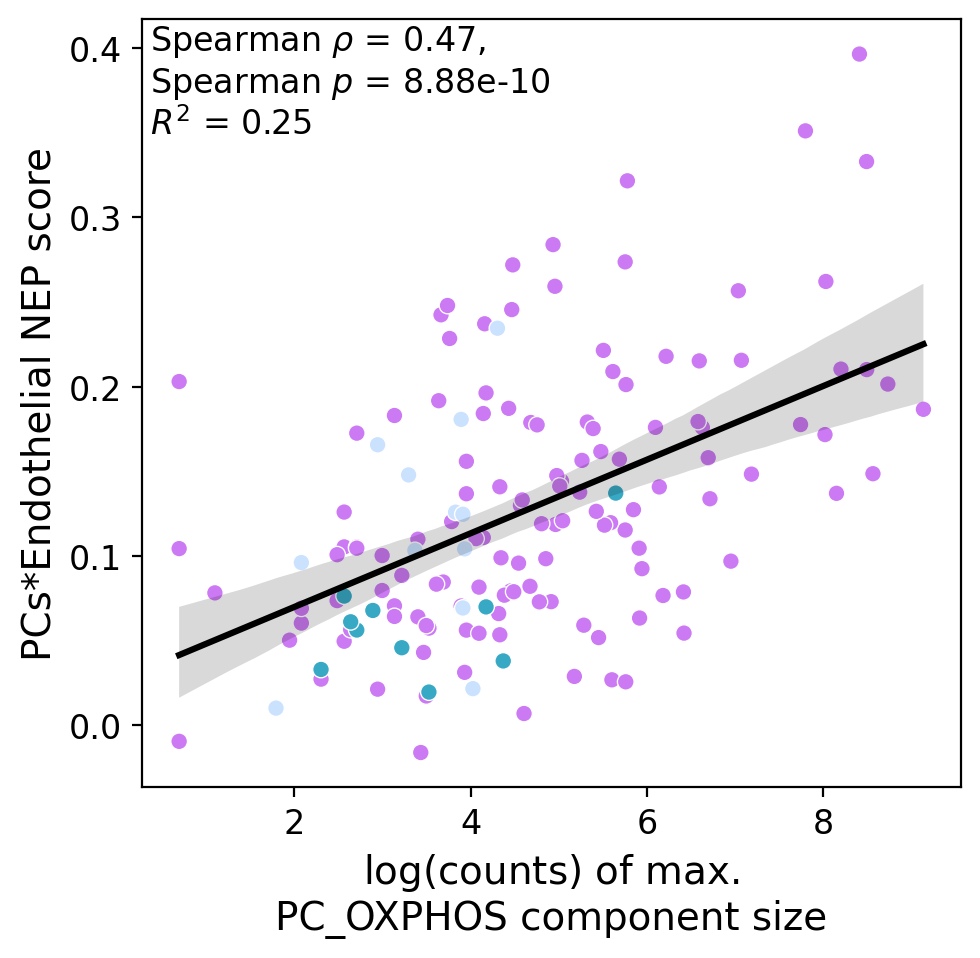

In [18]:
plt.style.use('default')
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x='count',
    y='PCs*Endothelial',
    data=merged,
    hue='disease3',
    palette=disease3_color_map,
    legend=False)
sns.regplot(
    x='count',
    y='PCs*Endothelial',
    data=merged,
    scatter=False,
    color='black'
)
# Select 'count' as a DataFrame (2D)
X = merged[['count']]
y = merged['PCs*Endothelial']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = model.score(X, y)
sns.lineplot
stat, p = spearmanr(merged['count'], merged['PCs*Endothelial'])
plt.text(0.01, 0.85, f'Spearman $\\rho$ = {stat:.2f}, \nSpearman $p$ = {p:.2e} \n$R^2$ = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel(r'$\log(\text{counts})$ of max.' + '\n' + r'PC_OXPHOS component size', fontsize=14)
plt.ylabel('PCs*Endothelial NEP score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'interaction_pc_ec_correlation_componentsize.{extension}'))

# H

In [25]:
adata_mm = adata.copy()

In [26]:
cc.gr.connected_components(adata_mm, cluster_key='cellcharter_CN', min_cells=60)

In [27]:
adata_mm = adata_mm[~adata_mm.obs['component'].isna()]
adata_mm

View of AnnData object with n_obs × n_vars = 378385 × 33
    obs: 'Object', 'area', 'Y_centroid', 'X_centroid', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'distance_to_bone', 'image_ID', 'disease', 'patient_ID', 'ROI', 'disease2', 'distance_to_bone_corrected', 'cellcharter_CN', 'Phenotype4', 'HistoneH3', 'disease3', 'component'
    var: 'name', 'channel', 'deepcell', 'mean', 'std'
    uns: 'Phenotype4_colors', 'cellcharter_CN_colors', 'spatial', 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'arcsinh', 'zscore'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [28]:
markers = [
    'ATP5A', 'GLUT1', 'PKM2', 'CPT1A', 'CD36', 'CD98', 'HIF1A', 'CS', 'IL32',]

In [29]:
celltype = 'PCs'
cell = adata_mm[adata_mm.obs['Phenotype4'] == celltype]
cell_subset = cell[cell.obs[f'cellcharter_CN'].isin(['PC_OXPHOS', 'PC_MYELOID'])].copy()
df = cell_subset.to_df()
df['cellcharter_CN'] = cell_subset.obs['cellcharter_CN']
df['image_ID'] = cell_subset.obs['image_ID']
df2 = df.groupby(['cellcharter_CN', 'image_ID']).median().reset_index().dropna()
with plt.rc_context({"figure.figsize": (2, 3)}):
    for marker in markers:
        axes = sns.violinplot(x='cellcharter_CN', y=marker, data=df2, palette=neighborhood_color_map, inner='box')
        axes.set_title(f'')
        
        # Get current y-axis limits
        ymin, ymax = axes.get_ylim()
        # Set new y-axis limits with 0.5 added to the max limit
        axes.set_ylim(0, 1.1)
        axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize=12)
        axes.set_yticklabels(axes.get_yticklabels(), fontsize=12)
        axes.set_ylabel(f'{marker} (CLR)', fontsize=14)
        axes.set_xlabel('')
        
        fig = axes.figure
        fig.savefig(os.path.join(save_path, f'violin_{celltype}_{marker}_per_image.{extension}'), 
                    dpi=300, 
                    bbox_inches='tight',
                    pad_inches=0.1), 
        group1 = df2[df2['cellcharter_CN'] == 'PC_OXPHOS'][marker]
        group2 = df2[df2['cellcharter_CN'] == 'PC_MYELOID'][marker]
        stat, p_value = mannwhitneyu(group1, group2)
        print(f'{marker}: {p_value}')
        plt.close(fig)

ATP5A: 0.01207422465127977
GLUT1: 2.2421019895438998e-06
PKM2: 0.032513736775874914
CPT1A: 0.027885147091811203
CD36: 0.032513736775874914
CD98: 1.7588907767700708e-08
HIF1A: 0.008552658469379332
CS: 0.0007427372486522929
IL32: 0.1730028597126857
